# 1. Khởi tạo và chuẩn bị data

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import community.community_louvain as community_louvain # Thư viện phát hiện cộng đồng

# Cấu hình
INPUT_GRAPH_PATH = r"C:\Users\Dell\Downloads\facebook_combined_cleaned.txt"
ROLE_TABLE_PATH = r"C:\Users\Dell\Downloads\role_table.csv"

# 1. Tải đồ thị G_clean
print(f"Loading G_clean from: {INPUT_GRAPH_PATH}")
G_clean = nx.read_edgelist(INPUT_GRAPH_PATH, create_using=nx.Graph(), nodetype=str)
print(f"Graph loaded: {G_clean.number_of_nodes()} nodes, {G_clean.number_of_edges()} edges.")

# 2. Tải Role Table
print(f"Loading Role Table from: {ROLE_TABLE_PATH}")
df_roles = pd.read_csv(ROLE_TABLE_PATH)
df_roles['NodeID'] = df_roles['NodeID'].astype(str)

print("✅ Dữ liệu đã sẵn sàng!")

Loading G_clean from: C:\Users\Dell\Downloads\facebook_combined_cleaned.txt
Graph loaded: 4039 nodes, 88234 edges.
Loading Role Table from: C:\Users\Dell\Downloads\role_table.csv
✅ Dữ liệu đã sẵn sàng!


# 2. Xác định Hạt giống (Seeding Strategies)

- Chọn ra 10 nút đại diện cho mỗi chiến lược: Hubs (Người nổi tiếng), Bridges (Người cầu nối), và Random (Ngẫu nhiên)

In [ ]:
K_SEEDS = 10 # Số lượng hạt giống (ngân sách)

# Chiến lược A: HUBS (Top Degree Centrality)
# Sắp xếp giảm dần theo DegreeCentrality và lấy top K
top_hubs = df_roles.sort_values(by='DegreeCentrality', ascending=False).head(K_SEEDS)['NodeID'].tolist()

# Chiến lược B: BRIDGES (Top Betweenness)
# Sắp xếp giảm dần theo BetweennessCentrality và lấy top K
top_bridges = df_roles.sort_values(by='Betweenness', ascending=False).head(K_SEEDS)['NodeID'].tolist()

# Chiến lược C: RANDOM (Baseline)
# Chọn ngẫu nhiên K nút từ đồ thị
all_nodes = list(G_clean.nodes())
random_seeds = random.sample(all_nodes, K_SEEDS)

print(f"--- DANH SÁCH SEEDS (K={K_SEEDS}) ---")
print(f"1. HUBS Seeds (Strategy A): {top_hubs}")
print(f"2. BRIDGES Seeds (Strategy B): {top_bridges}")
print(f"3. RANDOM Seeds (Strategy C): {random_seeds} (Mẫu ngẫu nhiên)")

# Kiểm tra xem Hubs và Bridges có trùng nhau nhiều không
overlap = set(top_hubs).intersection(top_bridges)
print(f"\nSố lượng trùng lặp giữa Hubs và Bridges: {len(overlap)}/{K_SEEDS}")

--- DANH SÁCH SEEDS (K=10) ---
1. HUBS Seeds (Strategy A): ['107', '1684', '1912', '3437', '0', '2543', '2347', '1888', '1800', '1663']
2. BRIDGES Seeds (Strategy B): ['107', '1684', '3437', '1912', '1085', '0', '698', '567', '58', '428']
3. RANDOM Seeds (Strategy C): ['18', '2902', '961', '651', '3438', '1668', '492', '3768', '3121', '793'] (Mẫu ngẫu nhiên)

Số lượng trùng lặp giữa Hubs và Bridges: 5/10


- Lấy Bản đồ Cộng đồng

In [ ]:
print("Đang phân hoạch cộng đồng để đo lường độ thâm nhập...")

# Sử dụng Louvain để lấy nhãn cộng đồng cho mỗi nút
# partition là một dict: {NodeID: CommunityID}
partition = community_louvain.best_partition(G_clean)

# Đếm tổng số cộng đồng
num_communities = len(set(partition.values()))
print(f"✅ Đã xác định được {num_communities} cộng đồng khác nhau trong mạng lưới.")

# Ví dụ: Xem nút '0' thuộc cộng đồng nào
print(f"Ví dụ: Node '0' thuộc Community {partition.get('0', 'Unknown')}")

Đang phân hoạch cộng đồng để đo lường độ thâm nhập...
✅ Đã xác định được 16 cộng đồng khác nhau trong mạng lưới.
Ví dụ: Node '0' thuộc Community 12


# 3.Xây dựng Động cơ Mô phỏng (SIR Simulation Engine)

- Hàm mô phỏng quá trình lây lan virus/tin tức theo mô hình SIR:
    + S (Susceptible): Chưa biết tin
    + I (Infected): Đang biết tin và đi lan truyền (seeding)
    + R (Recovered): Đã biết tin và ngừng lan truyền (hoặc đã miễn dịch)

In [ ]:
def run_advanced_sir(G, seeds, community_map, beta=0.05, gamma=0.1, max_steps=50):
    """
    Mô phỏng SIR nâng cấp: Theo dõi cả Reach (Số người) và Community Penetration (Số cộng đồng).
    """
    status = {node: 0 for node in G.nodes()} # 0: S, 1: I, 2: R

    # Theo dõi các cộng đồng đã bị nhiễm (Set of infected community IDs)
    infected_communities = set()

    # Kích hoạt seeds
    for seed in seeds:
        if seed in status:
            status[seed] = 1
            # Ghi nhận cộng đồng của seed này
            if seed in community_map:
                infected_communities.add(community_map[seed])

    history_reach = []      # Tổng số người (I + R)
    history_community = []  # Tổng số cộng đồng đã chạm tới

    for t in range(max_steps):
        # 1. Ghi lại chỉ số hiện tại
        count_I = sum(1 for n in status if status[n] == 1)
        count_R = sum(1 for n in status if status[n] == 2)
        total_affected = count_I + count_R

        history_reach.append(total_affected)
        history_community.append(len(infected_communities))

        if count_I == 0: # Hết dịch
            # Fill nốt các bước còn lại bằng giá trị cuối
            history_reach.extend([total_affected] * (max_steps - t - 1))
            history_community.extend([len(infected_communities)] * (max_steps - t - 1))
            break

        new_infected = []
        new_recovered = []

        # Duyệt các nút đang nhiễm (I)
        infected_nodes = [n for n, s in status.items() if s == 1]

        for u in infected_nodes:
            # Lây nhiễm
            for v in G.neighbors(u):
                if status[v] == 0:
                    if random.random() < beta:
                        new_infected.append(v)
            # Hồi phục
            if random.random() < gamma:
                new_recovered.append(u)

        # Cập nhật trạng thái và ghi nhận cộng đồng mới
        for n in new_infected:
            status[n] = 1
            if n in community_map:
                infected_communities.add(community_map[n]) # Thêm cộng đồng mới vào danh sách

        for n in new_recovered:
            status[n] = 2

    return history_reach, history_community

# 4. Thực thi "Cuộc chiến Chiến lược" (The Strategy Battle)

- Chạy mô phỏng 100 lần cho mỗi chiến lược để lấy kết quả trung bình

In [ ]:
# Tham số (Giữ nguyên hoặc điều chỉnh Beta nhỏ lại để thấy rõ hiệu quả của Bridges)
BETA = 0.05
GAMMA = 0.1
STEPS = 50
N_TRIALS = 100

print(f"Running Advanced Simulation (Trials={N_TRIALS})...")

def run_trials_dual_metrics(G, seeds, comm_map, strategy_name):
    reach_results = []
    comm_results = []

    print(f"Strategy: {strategy_name}...")
    for _ in tqdm(range(N_TRIALS)):
        h_reach, h_comm = run_advanced_sir(G, seeds, comm_map, beta=BETA, gamma=GAMMA, max_steps=STEPS)
        reach_results.append(h_reach)
        comm_results.append(h_comm)

    # Tính trung bình
    avg_reach = np.mean(reach_results, axis=0)
    avg_comm = np.mean(comm_results, axis=0)
    return avg_reach, avg_comm

# Chạy 3 chiến lược
reach_hubs, comm_hubs = run_trials_dual_metrics(G_clean, top_hubs, partition, "HUBS")
reach_bridges, comm_bridges = run_trials_dual_metrics(G_clean, top_bridges, partition, "BRIDGES")
reach_random, comm_random = run_trials_dual_metrics(G_clean, random_seeds, partition, "RANDOM")

print("Hoàn tất mô phỏng!")

Running Advanced Simulation (Trials=100)...
Strategy: HUBS...


100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


Strategy: BRIDGES...


100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


Strategy: RANDOM...


100%|██████████| 100/100 [00:13<00:00,  7.49it/s]

Hoàn tất mô phỏng!


# 5. Trực quan hóa & Kết luận

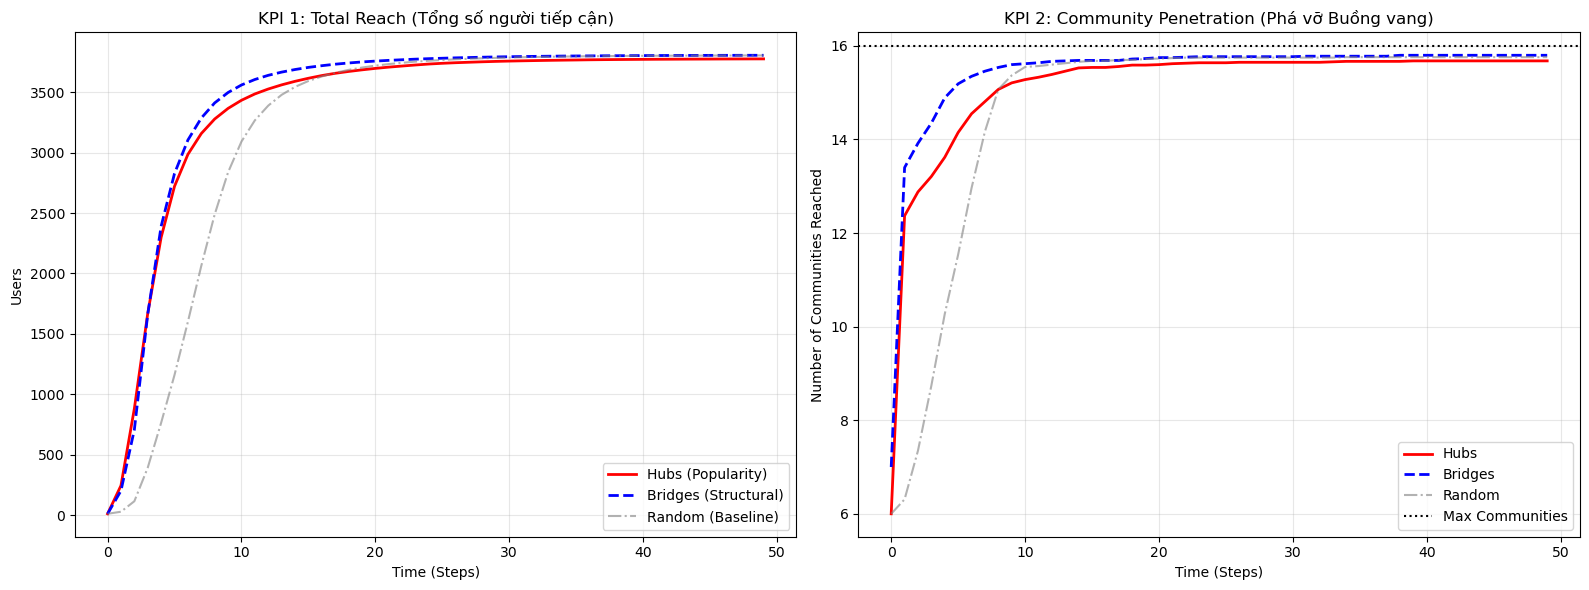


--- BẢNG TỔNG HỢP KẾT QUẢ (Sau 50 bước) ---
STRATEGY   | REACH (People)  | COMMUNITIES     | PENETRATION RATE    
----------------------------------------------------------------------
HUBS       | 3777            | 15.7 /16        | 98.00%
BRIDGES    | 3807            | 15.8 /16        | 98.75%
RANDOM     | 3805            | 15.8 /16        | 98.50%

--- PHÂN TÍCH & KẾT LUẬN ---
✅ Về khả năng phá vỡ buồng vang: BRIDGES hiệu quả hơn HUBS (+0.75% tỷ lệ thâm nhập).
   -> Chứng tỏ: Những người cầu nối giúp tin tức đi xa hơn qua các nhóm khác nhau.

📊 HIỆU QUẢ SO VỚI CHỌN NGẪU NHIÊN (RANDOM):
   - Chiến lược BRIDGES giúp tăng lượng người tiếp cận thêm 0.03% so với chọn ngẫu nhiên.
   - Về độ phủ cộng đồng, chiến lược tối ưu giúp thâm nhập thêm 0.25% tổng số cộng đồng so với Random.

=> KẾT LUẬN CHUNG: Việc sử dụng SNA (đặc biệt là Bridges) mang lại lợi thế rõ rệt trong việc tối ưu hóa lan truyền thông tin đa chiều.


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. BIỂU ĐỒ TOTAL REACH (SỐ NGƯỜI)
x = range(STEPS)
ax1.plot(x, reach_hubs, label='Hubs (Popularity)', color='red', linewidth=2)
ax1.plot(x, reach_bridges, label='Bridges (Structural)', color='blue', linewidth=2, linestyle='--')
ax1.plot(x, reach_random, label='Random (Baseline)', color='gray', alpha=0.6, linestyle='-.') # Thêm style cho Random

ax1.set_title('KPI 1: Total Reach (Tổng số người tiếp cận)')
ax1.set_xlabel('Time (Steps)')
ax1.set_ylabel('Users')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. BIỂU ĐỒ COMMUNITY PENETRATION (THÂM NHẬP CỘNG ĐỒNG)
ax2.plot(x, comm_hubs, label='Hubs', color='red', linewidth=2)
ax2.plot(x, comm_bridges, label='Bridges', color='blue', linewidth=2, linestyle='--')
ax2.plot(x, comm_random, label='Random', color='gray', alpha=0.6, linestyle='-.')

# Vẽ đường giới hạn tổng số cộng đồng
ax2.axhline(y=num_communities, color='black', linestyle=':', label='Max Communities')

ax2.set_title('KPI 2: Community Penetration (Phá vỡ Buồng vang)')
ax2.set_xlabel('Time (Steps)')
ax2.set_ylabel('Number of Communities Reached')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('final_kpi_dashboard.png')
plt.show()

# --- PHẦN KẾT LUẬN CHI TIẾT (Đã bổ sung Random) ---
print(f"\n--- BẢNG TỔNG HỢP KẾT QUẢ (Sau {STEPS} bước) ---")
print(f"{'STRATEGY':<10} | {'REACH (People)':<15} | {'COMMUNITIES':<15} | {'PENETRATION RATE':<20}")
print("-" * 70)

# Tính toán các chỉ số
rate_hubs = (comm_hubs[-1] / num_communities) * 100
rate_bridges = (comm_bridges[-1] / num_communities) * 100
rate_random = (comm_random[-1] / num_communities) * 100

print(f"HUBS       | {reach_hubs[-1]:<15.0f} | {comm_hubs[-1]:<5.1f}/{num_communities:<9} | {rate_hubs:.2f}%")
print(f"BRIDGES    | {reach_bridges[-1]:<15.0f} | {comm_bridges[-1]:<5.1f}/{num_communities:<9} | {rate_bridges:.2f}%")
print(f"RANDOM     | {reach_random[-1]:<15.0f} | {comm_random[-1]:<5.1f}/{num_communities:<9} | {rate_random:.2f}%")

print("\n--- PHÂN TÍCH & KẾT LUẬN ---")

# 1. So sánh Bridges vs Hubs (Về khả năng phá buồng vang)
if rate_bridges > rate_hubs:
    diff_comm = rate_bridges - rate_hubs
    print(f"✅ Về khả năng phá vỡ buồng vang: BRIDGES hiệu quả hơn HUBS (+{diff_comm:.2f}% tỷ lệ thâm nhập).")
    print("   -> Chứng tỏ: Những người cầu nối giúp tin tức đi xa hơn qua các nhóm khác nhau.")
else:
    print(f"✅ Về khả năng phá vỡ buồng vang: HUBS đang dẫn trước.")

# 2. So sánh với Baseline (Random)
# So sánh Reach của chiến lược tốt nhất với Random
best_reach_val = max(reach_hubs[-1], reach_bridges[-1])
best_strat_name = "BRIDGES" if reach_bridges[-1] >= reach_hubs[-1] else "HUBS"
reach_gain = ((best_reach_val - reach_random[-1]) / reach_random[-1]) * 100

print(f"\n📊 HIỆU QUẢ SO VỚI CHỌN NGẪU NHIÊN (RANDOM):")
if reach_gain > 0:
    print(f"   - Chiến lược {best_strat_name} giúp tăng lượng người tiếp cận thêm {reach_gain:.2f}% so với chọn ngẫu nhiên.")

    # So sánh về Communities
    best_rate_val = max(rate_hubs, rate_bridges)
    comm_gain_rate = best_rate_val - rate_random
    print(f"   - Về độ phủ cộng đồng, chiến lược tối ưu giúp thâm nhập thêm {comm_gain_rate:.2f}% tổng số cộng đồng so với Random.")

    print("\n=> KẾT LUẬN CHUNG: Việc sử dụng SNA (đặc biệt là Bridges) mang lại lợi thế rõ rệt trong việc tối ưu hóa lan truyền thông tin đa chiều.")
else:
    print("   - Chiến lược Random đang hoạt động tương đương hoặc tốt hơn. (Cần xem lại tham số mô phỏng hoặc cấu trúc mạng lưới đặc thù).")